# <center><span style="font-size: 50px; color: blue;">LIVRABLE 1</span></center>

<center><span style="font-size: 20px; color: purple;">Correlation between the potential temperature $\Theta_{tp}$ and the geopotential height $z$</span></center>
<p></p>

In [1]:
import numpy as np
from sklearn import linear_model
import seaborn as sns
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.animation as animation
from IPython.display import HTML

## <center>Part 1 - import the data

In [2]:
data = nc.Dataset('Donnees/Donnees_PIE_Meteo.nc')

Let's have a look to the dimensions:

In [3]:
list(data.dimensions.values())

[<class 'netCDF4._netCDF4.Dimension'>: name = 'initial_time0_hours', size = 31,
 <class 'netCDF4._netCDF4.Dimension'>: name = 'g0_lat_1', size = 361,
 <class 'netCDF4._netCDF4.Dimension'>: name = 'g0_lon_2', size = 720,
 <class 'netCDF4._netCDF4.Dimension'>: name = 'ncl_strlen_0', size = 18]

So we have the following structure:
- First axis is **time**: 31 samples
- Second axis is **latitude**: 361 samples
- Third axis is **longitude**: 720 samples

In [4]:
hours = np.copy(data['initial_time0_hours'])
days = range(len(hours))
print('Instants of measure (hrs):\n')
print(hours)
print('\n\nDelays between 2 consecutives measures (hrs):\n')
print(hours[1:]-hours[:-1])

Instants of measure (hrs):

[1893408. 1893432. 1893456. 1893480. 1893504. 1893528. 1893552. 1893576.
 1893600. 1893624. 1893648. 1893672. 1893696. 1893720. 1893744. 1893768.
 1893792. 1893816. 1893840. 1893864. 1893888. 1893912. 1893936. 1893960.
 1893984. 1894008. 1894032. 1894056. 1894080. 1894104. 1894128.]


Delays between 2 consecutives measures (hrs):

[24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24.
 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24.]


Hence, the 31 data points are uniformly distributed over 31 days.

What about the variables of interest?

In [5]:
list(data.variables.values())[:2]

[<class 'netCDF4._netCDF4.Variable'>
 float32 GP_GDS0_PVL(initial_time0_hours, g0_lat_1, g0_lon_2)
     forecast_time_units: hours
     forecast_time: 0
     level: 2000
     parameter_number: 6
     parameter_table_version: 1
     gds_grid_type: 0
     level_indicator: 117
     _FillValue: 1e+20
     units: m^2/s^2
     long_name: Geopotential
     center: French Weather Service - Toulouse
 unlimited dimensions: 
 current shape = (31, 361, 720)
 filling on, <class 'netCDF4._netCDF4.Variable'>
 float32 POT_GDS0_PVL(initial_time0_hours, g0_lat_1, g0_lon_2)
     forecast_time_units: hours
     forecast_time: 0
     level: 2000
     parameter_number: 13
     parameter_table_version: 1
     gds_grid_type: 0
     level_indicator: 117
     _FillValue: 1e+20
     units: K
     long_name: Potential temperature
     center: French Weather Service - Toulouse
 unlimited dimensions: 
 current shape = (31, 361, 720)
 filling on]

So we have:
- 'GP_GDS0_PV': The geopotential $\Phi \, (m^2.s^{-2})$ at the tropopause
- 'POT_GDS0_PV': The potential temperature $\Theta_{tp} \, (K)$ (temperature that would get the fluid driven adiabatically under a pressure $P_0=1000 \, hPa$)

**These data have a shape [31,361,720]**

The geopotential height $z \, (m)$ is linked to $\Phi$ by the relation:
$$z=\frac{\Phi}{g_0}$$
Where $g_0$ refers to the well known standard gravity at sea level.  
We are going to extract the fields of interest $\Theta_{tp}$ and $z$ into the arrays *temp_pot* and *geop_hgt*:

In [6]:
g0 = 9.80665 # standard gravity at sea level m.s^-2
geop_hgt = np.copy(data['GP_GDS0_PVL'])/g0  # (m)
temp_pot = np.copy(data['POT_GDS0_PVL'])    # (K)

We encapsulate each variable into a dictionnary containing also its name:

In [7]:
var_geop_hgt = {'field': 1e-3*geop_hgt,
                'title': r'Geopotential height $z \, (km)$'}
var_temp_pot = {'field': temp_pot,
                'title': r'Potential temperature $\Theta_{tp} \, (K)$'}

## <center>Part 2 - plotting the fields

### a) At a given time

Let's build a function that plots a given 2D field at a given time:

In [8]:
def plot_field(field, title, day=None, throwback=False,
               fontsize=20, cmap='magma', vmin=None, vmax=None,
               stretch=lambda x: x, stretch_inv=lambda y: y):

    # get the field to plot
    used_field = stretch(field[day,:,:]) if day is not None else stretch(field)
    
    # set the figure
    fig = plt.figure(figsize=(12,8))
    ax = plt.subplot(111)
    ax.set_title(title, fontsize=fontsize+5, pad=15)
    ax.set_yticks([1,90, 180, 270, 360]) 
    ax.set_yticklabels([r'$90°$',r'$45°$', r'$0°$', r'$-45°$', r'$-90°$']) 
    ax.set_xticks([1,90, 180, 270, 360, 450, 540, 630, 719]) 
    ax.set_xticklabels([r'$0°$',r'$45°$',r'$90°$',r'$135°$', r'$180°$', r'$225°$',r'$270°$',r'$315°$', r'$360°$']) 
    ax.tick_params(labelsize=15, direction='in', length=10, width=1, pad=5, color='white')
    ax.set_ylabel(r'Latitude $(°)$', fontsize=fontsize)
    ax.set_xlabel(r'Longitude $(°)$', fontsize=fontsize)
    
    # set the colorbar
    vmin = np.min(used_field) if vmin is None else vmin
    vmax = np.max(used_field) if vmax is None else vmax
    cbar = fig.colorbar(ScalarMappable(cmap=cmap, norm=Normalize(vmin=vmin, vmax=vmax)), ax=ax)
    cbar_ticks = cbar.get_ticks()
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(list(map(lambda y: '{:.2f}'.format(stretch_inv(y)), cbar_ticks)))
    
    # plot the field
    ax.imshow(used_field, cmap=cmap, vmin=vmin, vmax=vmax)
    
    if throwback:
        return fig    # returns the figure (e.g. when called to build a video)
    else:
        plt.show()
        plt.close()   # otherwise plots simply the figure
        return

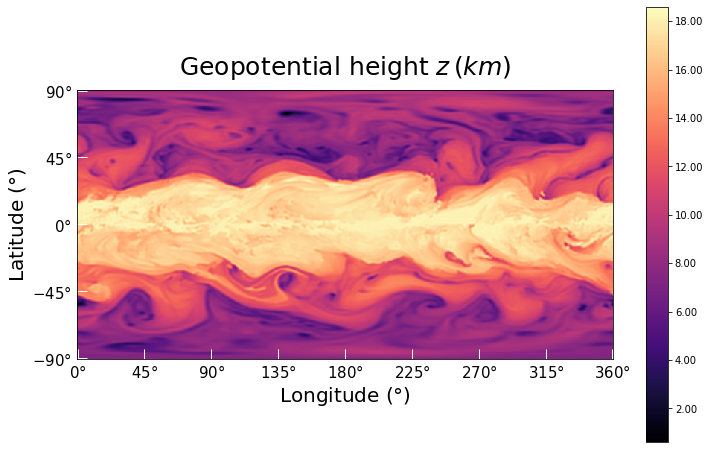

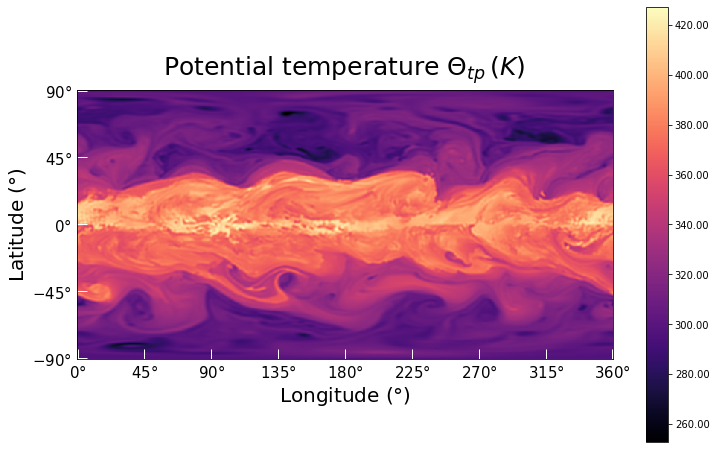

In [9]:
day = 28 # day number should be between 0 and 30
plot_field(day=day, **var_geop_hgt)
plot_field(day=day, **var_temp_pot)

### b) Generating animations

Let's now build a function that generates a video:

In [10]:
def video(field, title, fontsize=20, cmap='magma'):
    
    # initialisation of the figure with the first day
    fig = plot_field(field=field,
                     title=title,
                     day=0,
                     cmap=cmap,
                     vmin=np.min(field),
                     vmax=np.max(field),
                     throwback=True)
    
    # generating the images of each day
    frames = list(map(lambda day: [plt.imshow(field[day,:,:],
                                              cmap=cmap,
                                              vmin=np.min(field),
                                              vmax=np.max(field))],
                      days))
    
    return animation.ArtistAnimation(fig, frames, interval=200, blit=True, repeat=False)

Let's generate the videos...

In [14]:
%%capture
video_geop_hgt = HTML(video(**var_geop_hgt).to_html5_video())
video_temp_pot = HTML(video(**var_temp_pot).to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available

...and plot them:

In [15]:
video_geop_hgt

NameError: name 'video_geop_hgt' is not defined

In [16]:
video_temp_pot

NameError: name 'video_temp_pot' is not defined

As we can see qualitatively in these animations, the 2 quantities $\Theta_{tp}$ and $z$ are **extremely correlated**! Let's investigate this more in details...

## <center>Part 3 - pointwise regression

To perform a correlation between $\Theta_{tp}$ and $z$ we have to extract 2 samples were these 2 quantities are jointly measured. A first way to do this is just to set a fixed point $(\phi,\lambda)$ ($\phi$ denotes the latitude and $\lambda$ the longitude) and analyze the 2 time series $\{\Theta_{tp}(\phi,\lambda,t)\}_t$ and $\{z(\phi,\lambda,t)\}_t$. This is what we call a 'pointwise regression', because we perform, for each point $(\phi,\lambda)$ a regression over its time series.
- The function *get_pointwise_series* computes these 2 series for a given couple $(i,j)$ denoting the coordinates $(\phi_i,\lambda_j)$.
- We can then perform a linear regression and plot the results using the function *plot_regression*.

In [17]:
def get_pointwise_series(i, j):
    return var_geop_hgt['field'][::,i,j], var_temp_pot['field'][::,i,j]

def plot_regression(x, y):
    data = pd.DataFrame()
    data[var_geop_hgt['title']], data[var_temp_pot['title']] = x, y
    sns.lmplot(x=var_geop_hgt['title'], y=var_temp_pot['title'], data=data)
    regression = linear_model.LinearRegression().fit(x.reshape(-1,1), y.reshape(-1,1))
    plt.figtext(x=0.3, y=0.8, s=r'$R^2={:f}$'.format(regression.score(x.reshape(-1,1), y.reshape(-1,1))))

Here is a first plot at a random point $(\phi_{280}, \lambda_{500})$:

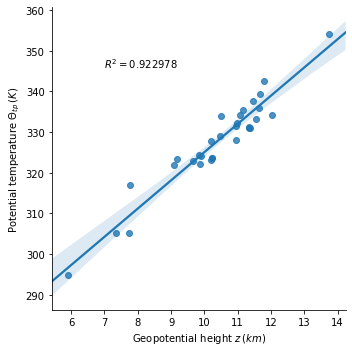

In [18]:
plot_regression(*get_pointwise_series(280, 500))

As we can see, the correlation $R^2$ is extremely good.  
Let us now investigate all the regions of the map:

In [19]:
n_lat, n_long = temp_pot.shape[1], temp_pot.shape[2]

try:
    r2s = pd.read_csv('Results/pointwise_regression/r2s.csv').to_numpy()
    coefs = pd.read_csv('Results/pointwise_regression/coefs.csv').to_numpy()
    intercepts = pd.read_csv('Results/pointwise_regression/intercepts.csv').to_numpy()
    print('Using saved results')
except:
    print('Computing and saving results')
    coefs = np.zeros((n_lat, n_long))
    intercepts = np.zeros((n_lat, n_long))
    r2s = np.zeros((n_lat, n_long))

    for i in range(n_lat):
        print(i)
        for j in range(n_long):
            x, y = get_pointwise_series(i, j)
            regression = linear_model.LinearRegression().fit(x.reshape(-1,1), y.reshape(-1,1))
            coefs[i,j] = regression.coef_
            intercepts[i,j] = regression.intercept_
            r2s[i,j] = regression.score(x.reshape(-1,1), y.reshape(-1,1))

    r2s_df = pd.DataFrame(data=r2s.astype(float))
    r2s_df.to_csv('Results/pointwise_regression/r2s.csv', float_format='%.6f', index=False)
    coefs_df = pd.DataFrame(data=coefs.astype(float))
    coefs_df.to_csv('Results/pointwise_regression/coefs.csv', float_format='%.6f', index=False)
    intercepts_df = pd.DataFrame(data=intercepts.astype(float))
    intercepts_df.to_csv('Results/pointwise_regression/intercepts.csv', float_format='%.6f', index=False)

Using saved results


Now it is time to plot these results:

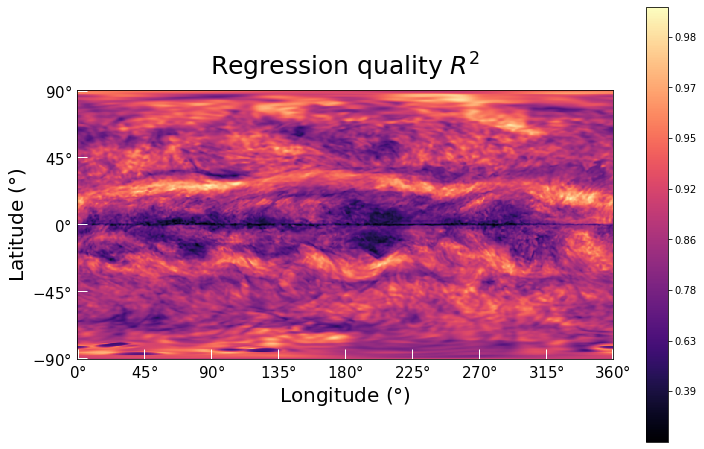

In [20]:
plot_field(field=r2s, title=r'Regression quality $R^2$',
           stretch=lambda x: -np.log(1-x), stretch_inv=lambda y: 1-np.exp(-y))

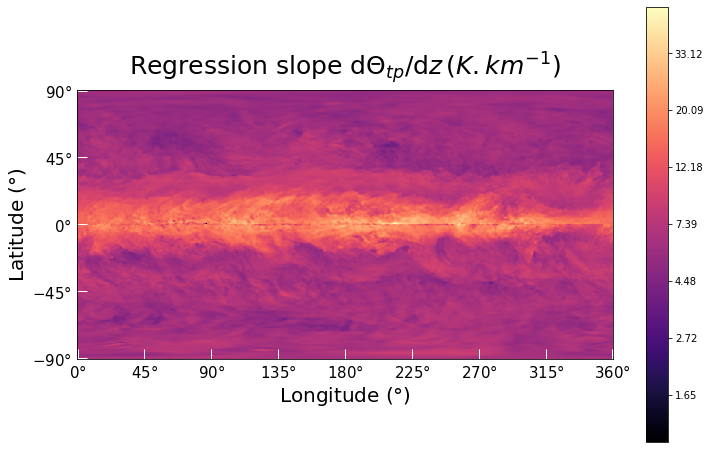

In [21]:
plot_field(field=coefs,
           title=r'Regression slope $\mathrm{d}\Theta_{tp}/\mathrm{d}z \, (K.km^{-1})$',
           stretch=lambda x: np.log(abs(x)), stretch_inv=lambda y: np.exp(y))

As we can see, these results operate well for $|\phi|>15-20°$, but the fit doesn't hold anymore next to the equator. This is due to the violation of the quasi-geostrophic hypothesis since the Coriolis force vanishes for $\phi=0$. We can see also that the results are quite uniform for a fixed latitude. This remark oriented us toward another type of regression.

## <center>Part 4 - latitude-wise regression

We remind that to perform a correlation between $\Theta_{tp}$ and $z$ we have to extract 2 samples were these 2 quantities are jointly measured. To do this, we make the choice now to set a fixed latitude $\phi$ and analyze the 2 joint series $\{\Theta_{tp}(\phi,\lambda,t)\}_{\lambda,t}$ and $\{z(\phi,\lambda,t)\}_{\lambda,t}$. This is what we call a 'latitude-wise regression', because we perform, for each latitude $\phi$ a regression over the series composed of all possible times and longitudes.

We can the perform a linear regression for each $\phi$ to get:

\begin{equation}\tag{$\phi\text{-Reg}$}\label{phireg}
    \Theta_{tp}(\phi,\lambda,t) = a_\phi z(\phi,\lambda,t) + b_\phi
\end{equation}

If we apply the zonal mean (*i.e* the average over longitudes $\langle \cdot \rangle_\lambda$) to \eqref{phireg} we get:

\begin{equation}\tag{$\langle\phi\text{-Reg}\rangle_\lambda$}\label{zonalavgphireg}
    \langle\Theta_{tp}\rangle_\lambda(\phi,t) = a_\phi \langle z\rangle_\lambda(\phi,t) + b_\phi
\end{equation}

Hence by substracting \eqref{phireg} - \eqref{zonalavgphireg} one get:

\begin{equation}\tag{$\text{Zonal-}\phi\text{-Reg}$}\label{zonalphireg}
    \Theta_{tp}(\phi,\lambda,t)-\langle\Theta_{tp}\rangle_\lambda(\phi,t) = a_\phi \big(z(\phi,\lambda,t) - \langle z\rangle_\lambda(\phi,t) \big)
\end{equation}

Following *Juckes (1994)* notations we introduce the true anomalies:
- the true anomaly $\delta z$, defined as the departure from an undisturbed tropopause height.
- the true anomaly $\Theta_{tp}'$, defined as the departure from a globally uniform basic state at rest.

and the zonal anomalies:
- $z(\phi,\lambda,t) - \langle z\rangle_\lambda(\phi,t)$
- $\Theta_{tp}(\phi,\lambda,t)-\langle\Theta_{tp}\rangle_\lambda(\phi,t)$

If we make the hypothesis that the true anomalies are close to the zonal ones, then the regression per latitude $\phi$ is simply:

$$\Theta_{tp}'(\phi,\lambda,t) = a_\phi \delta z(\phi, \lambda, t)$$

With the slope $a_\phi$ given by Juckes equation (3.9):

\begin{equation}\tag{Juckes 1994 eq. (3.9)}\label{Juckes}
    a_\phi = \sqrt{\Gamma_{troposphere}\Gamma_{stratosphere}}
\end{equation}

The function *get_iso_lat_series* computes these 2 series for a given integer $i$ denoting the latitude $\phi_i$:

In [22]:
def get_iso_lat_series(i):
    return var_geop_hgt['field'][::,i,::].reshape(-1), var_temp_pot['field'][::,i,::].reshape(-1)

Here is a first plot at a random latitude $\phi_{280}$ (but the same as the pointwise example):

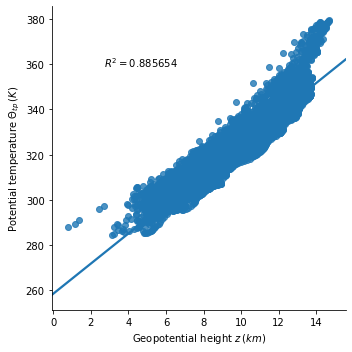

In [23]:
plot_regression(*get_iso_lat_series(280))

As we can see, the correlation $R^2$ is still very good: $0.89$, but lower than the one obtained by a pointwise regression for the same latitude: $0.92$. This was of course expected because when shifting from pointwise to latitude-wise regression, one reduces the degrees of freedom of the data fit from $2 \times 720$ to $2$... Hence, having such a high $R^2$ for the latitude-wise regression would be statistically unexpected unless if a physical explanation is behind. This remarquable type of result is of course the one that motivated Juckes to seek for physical explanations and modeling.

Let us now investigate all the regions of the map...

In [24]:
n_lat, n_long = temp_pot.shape[1], temp_pot.shape[2]

try:
    r2s_lat = pd.read_csv('Results/latwise_regression/r2s.csv').to_numpy()
    coefs_lat = pd.read_csv('Results/latwise_regression/coefs.csv').to_numpy()
    intercepts_lat = pd.read_csv('Results/latwise_regression/intercepts.csv').to_numpy()
    print('Using saved results')
except:
    print('Computing and saving results')
    coefs_lat = np.zeros(n_lat)
    intercepts_lat = np.zeros(n_lat)
    r2s_lat = np.zeros(n_lat)

    for i in range(n_lat):
        print(i)
        x, y = get_iso_lat_series(i)
        regression = linear_model.LinearRegression().fit(x.reshape(-1,1), y.reshape(-1,1))
        coefs_lat[i] = regression.coef_
        intercepts_lat[i] = regression.intercept_
        r2s_lat[i] = regression.score(x.reshape(-1,1), y.reshape(-1,1))

    r2s_lat_df = pd.DataFrame(data=r2s_lat.astype(float))
    r2s_lat_df.to_csv('Results/latwise_regression/r2s.csv', float_format='%.6f', index=False)
    coefs_lat_df = pd.DataFrame(data=coefs_lat.astype(float))
    coefs_lat_df.to_csv('Results/latwise_regression/coefs.csv', float_format='%.6f', index=False)
    intercepts_lat_df = pd.DataFrame(data=intercepts_lat.astype(float))
    intercepts_lat_df.to_csv('Results/latwise_regression/intercepts.csv', float_format='%.6f', index=False)
    r2s_lat = r2s_lat.reshape(-1,1)
    coefs_lat = coefs_lat.reshape(-1,1)
    intercepts_lat = intercepts_lat.reshape(-1,1)

Using saved results


...and make the final plot!

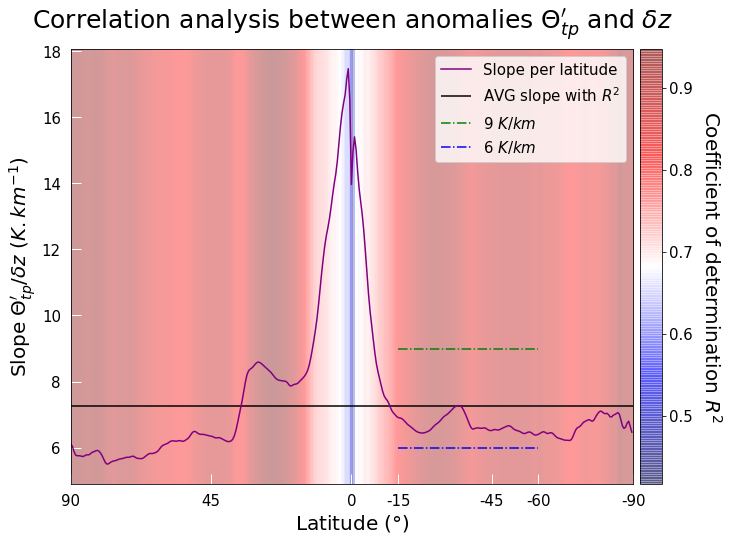

In [25]:
# set the figure
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(111)
ax.set_xticks([0,90, 180, 210, 270, 300, 361]) 
ax.set_xticklabels([90, 45, 0, -15, -45, -60, -90]) 
ax.tick_params(labelsize=15, direction='in', length=10, width=1, color='white', pad=10)
plt.xlabel(r'Latitude $(°)$', fontsize=20)
plt.ylabel(r"Slope $\Theta_{tp}'/\delta z$ $(K.km^{-1})$", fontsize=20)
plt.title(r"Correlation analysis between anomalies $\Theta_{tp}'$ and $\delta z$", fontsize=25, pad=20)

# plot the slope and some horizontal lines of reference
ax.plot(coefs_lat, color='purple', label='Slope per latitude')
plt.hlines(y=np.average(coefs_lat*r2s_lat)/np.average(r2s_lat), xmin=0, xmax=361, label=r'AVG slope with $R^2$')
plt.hlines(y=9, xmin=210, xmax=300, label=r'$9$ $K/km$', linestyle='-.', color='green')
plt.hlines(y=6, xmin=210, xmax=300, label=r'$6$ $K/km$', linestyle='-.', color='blue')

# plot the R^2
img = ax.imshow(r2s_lat.T, alpha=0.4, extent=[0,361,*ax.get_ylim()], aspect='auto', cmap='seismic')

# add the R^2 colorbar
cbar = plt.colorbar(img, pad=0.01)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label=r'Coefficient of determination $R^2$', fontsize=20, rotation=-90, labelpad=30)

plt.legend(fontsize=15, loc='upper right')
plt.show()

Juckes made a full regression (in the sense that the series included all possible times and points) over the region defined by $-60°<\phi<-15°$ (in the Southern Hemisphere) over $42$ days. His raw result was a slope of $9 \, K/km$ (green line). The blue line is the one computed using the relation  

$$\Theta_{tp}^{'}=\sqrt{\Gamma_{troposphere}\Gamma_{stratosphere}}\delta z$$  
with standard values for $\Gamma_{troposphere}$ and $\Gamma_{stratosphere}$. This is also the correlation result obtained by Juckes when removing the zonal means to estimate the true anomalies. Our results are in a good agreement with Juckes ones. The $R^2$ results are globally extremely good, except in the region $-15°<\phi<15°$, as mentioned before, because of the violation of the quasi-geostrophic paradigm.